In [1]:
import tensorflow as tf
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from PIL import Image, ImageEnhance

from utils import *

%load_ext autoreload
%autoreload 2
    
keras = tf.keras
MODEL_PATH = "models/3conv_1pool/"

In [2]:
(X_train_50000, y_train_50000), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [3]:
samples_for_training = 5000
X_train, y_train = X_train_50000[:samples_for_training], y_train_50000[:samples_for_training]

In [4]:
X_train.shape

(5000, 32, 32, 3)

In [5]:
y_train.shape

(5000, 1)

## Data visualization

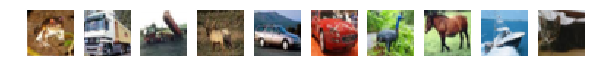

In [6]:
samples_to_show = 10
plt.figure(figsize=(10,10))
for iteration in range(samples_to_show):
    plt.subplot(samples_to_show, 10, iteration + 1)
    plot_image(X_train[iteration],shape=[32,32,3])

In [7]:
y_train[:samples_to_show]

array([[6],
       [9],
       [9],
       [4],
       [1],
       [1],
       [2],
       [7],
       [8],
       [3]], dtype=uint8)

## Explanation

| Label | Description |
| --- | --- |
| 0 | airplane |
| 1 | automobile |
| 2 | bird |
| 3 | cat |
| 4 | deer |
| 5 | dog |
| 6 | frog |
| 7 | horse |
| 8 | ship |
| 9 | truck |

### Resizing images to fit the InceptionV3's needs

In [8]:
from skimage.transform import resize 

X_train_resized = np.zeros((samples_for_training,75,75,3))

for iteration in range(samples_for_training):
    X_train_resized[iteration] = resize(X_train[iteration], (75,75,3),preserve_range=False)
    
np.asarray(X_train_resized).shape


C:\Users\antho\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\antho\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(5000, 75, 75, 3)

In [9]:
test_size = 10000
X_test_resized = np.zeros((test_size,75,75,3))

for iteration in range(test_size):
    X_test_resized[iteration] = resize(X_test[iteration], (75,75,3),preserve_range=False)

np.asarray(X_test_resized).shape

(10000, 75, 75, 3)

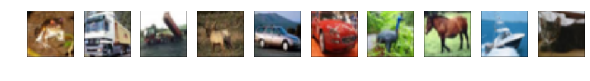

In [10]:
samples_to_show = 10
plt.figure(figsize=(10,10))
for iteration in range(samples_to_show):
    plt.subplot(samples_to_show, 10, iteration + 1)
    plot_image(X_train_resized[iteration],shape=[75,75,3])

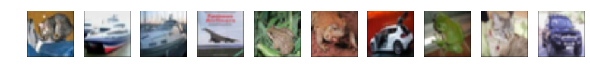

In [11]:
samples_to_show = 10
plt.figure(figsize=(10,10))
for iteration in range(samples_to_show):
    plt.subplot(samples_to_show, 10, iteration + 1)
    plot_image(X_test_resized[iteration],shape=[75,75,3])

### Getting InceptionV3 model

In [12]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input

input_tensor = Input(shape=(75, 75, 3))
base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

W0814 17:37:05.109365  6872 deprecation.py:506] From C:\Users\antho\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [13]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
# Adding a fully connected layer
x = Dense(1024, activation='relu')(x)
# Adding a fully connected layer for the 10 classes in CIFAR10
predictions = Dense(10, activation='softmax')(x)

In [14]:
model = Model(inputs=base_model.input, outputs=predictions)

# freeze all convolutional InceptionV3 layers
# we will only train the Dense layers added in "model"
for layer in base_model.layers:
    layer.trainable = False

# compile the model with adam optimizer and sparse_categorical_crossentropy loss function
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

To train the model we can use fit() of fit_generator(). Here the dataset fit in memory and I don't want to increase my dataset (rotation, translation, resizing, etc.) because I want to compare with the same number of image: with and without transfer learning.

Otherwise, I could use fit_generator() to use a Keras ImageDataGenerator as follow:
H = model.fit_generator(aug.flow(X_train, y_train, batch_size=100)
,validation_data=(X_test, y_test), steps_per_epoch=len(X_train) // BS, epochs=10)

In [15]:
history = model.fit(X_train_resized, y_train, batch_size=100, epochs=100, verbose=1)

Epoch 1/100
5000/5000 [==============================] - 67s 13ms/sample - loss: 2.2184 - sparse_categorical_accuracy: 0.2204
Epoch 2/100
5000/5000 [==============================] - 62s 12ms/sample - loss: 1.8528 - sparse_categorical_accuracy: 0.3654
Epoch 3/100
5000/5000 [==============================] - 64s 13ms/sample - loss: 1.7415 - sparse_categorical_accuracy: 0.4096
Epoch 4/100
5000/5000 [==============================] - 63s 13ms/sample - loss: 1.6615 - sparse_categorical_accuracy: 0.4394
Epoch 5/100
5000/5000 [==============================] - 64s 13ms/sample - loss: 1.6130 - sparse_categorical_accuracy: 0.4496
Epoch 6/100
5000/5000 [==============================] - 61s 12ms/sample - loss: 1.5524 - sparse_categorical_accuracy: 0.4676
Epoch 7/100
5000/5000 [==============================] - 64s 13ms/sample - loss: 1.5205 - sparse_categorical_accuracy: 0.4808
Epoch 8/100
5000/5000 [==============================] - 61s 12ms/sample - loss: 1.4457 - sparse_categorical_accuracy:

In [16]:
score = model.evaluate(X_test_resized,y_test, verbose=1) 

10000/10000 [==============================] - 88s 9ms/sample - loss: 5.4904 - sparse_categorical_accuracy: 0.2498


In [17]:
model.metrics_names

['loss', 'sparse_categorical_accuracy']

In [20]:
score

[5.490382891845703, 0.2498]

Text(0.5, 1.0, 'Training Accuracy')

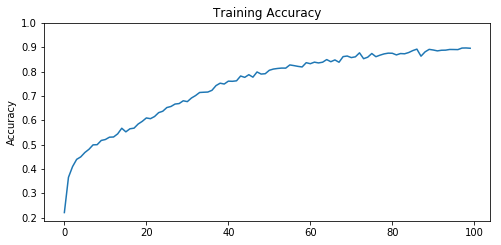

In [22]:
acc = history.history['sparse_categorical_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')